In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from exp.nb_05b import *
torch.set_num_threads(2)

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [8]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [10]:
#export 
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x)


def flatten(x):
    return x.view(x.shape[0], -1)


In [13]:
## Make a medium article on this.
def mnist_resize(x): 
    return x.view(-1, 1, 28, 28)

In [14]:
# (1,8) => (8, 16) => (16, 32) => (32, 32) 

def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        
        nn.Conv2d(1, 8, 5, padding=2, stride=2),
        nn.ReLU(),
        
        nn.Conv2d(8, 16, 3, padding=1, stride=2),
        nn.ReLU(),
        
        nn.Conv2d(16, 32, 3, padding=1, stride=2),
        nn.ReLU(),
                
        nn.Conv2d(32, 32, 3, padding=1, stride=2),
        nn.ReLU(),
        
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [15]:
model = get_cnn_model(data)

In [16]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [17]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [18]:
%time run.fit(1, learn)

train: [2.1032025, tensor(0.2274)]
valid: [1.09785283203125, tensor(0.6082)]
CPU times: user 14.3 s, sys: 689 ms, total: 15 s
Wall time: 5.08 s


In [19]:
def conv2d(ni, no, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, no, ks, padding=ks//2, stride=stride),
        nn.ReLU()
    )


In [20]:
# Let's mnist resize in a batch transform, that we can do with a callback

class BatchTransformXCallback(Callback):
    _order=2
    
    def __init__(self, tfm):
        self.tfm = tfm

    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    print(size)
    #(-1,) + (1,28,28) = (-1, 1, 28, 28)
    fn = lambda x: x.view((-1,) + size)
    return fn

    

In [21]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

(1, 28, 28)


In [22]:
nfs = [8, 16, 32, 32]

In [23]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3)
        for i in range(len(nfs) - 1)
    ] + [
        nn.AdaptiveAvgPool2d(1), 
        Lambda(flatten), 
        nn.Linear(nfs[-1], data.c)
    ]

def get_cnn_model(data, nfs): 
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [24]:
#export

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD    
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [25]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [27]:
# Runner instance maintains hooks and delegate fit
# to model while executing necessary hooks during 
# the life cycle of the training

run.fit(1, learn)

train: [1.61842375, tensor(0.4524)]
valid: [0.42041064453125, tensor(0.8663)]


In [28]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x

    def __iter__(self):
        return iter(self.layers)
            

In [29]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [30]:
# This Runner#fit method will start the lifecycle of training loop
# Therefore necessary hooks are invoked accordingly
run.fit(2, learn)

train: [2.0396309375, tensor(0.2799)]
valid: [0.935962890625, tensor(0.7069)]
train: [0.573075703125, tensor(0.8169)]
valid: [0.213240185546875, tensor(0.9357)]


In [38]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Lambda()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [33]:
# Inspect the first layer of the model
model.layers[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)

In [34]:
# Inspect the weight matrix in Conv2d layer in the first layer
model.layers[1][0].weight.view(-1).shape

torch.Size([1152])

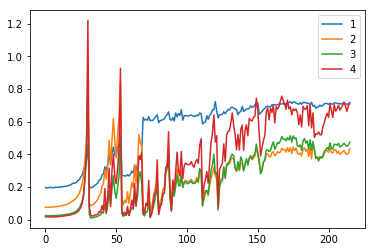

In [35]:
# Ispect means for echh actiovation layer over training iterations
# Only first few Conv2D's activations are interested
# What is happening at each spikes ?
for l in model.act_means[:4]: plt.plot(l)
plt.legend(range(1,7))

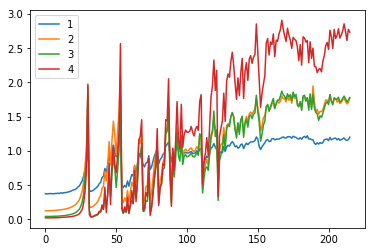

In [37]:
# Inspect stds for each activation layer over iterations
# Why activations varies toward the end
# Will they saturate and converge later ?
# Higher variance vs Lower variance
# What number will the variance converge to ?
# Does the converge mean something ?
for l in model.act_stds[:4]: plt.plot(l)
plt.legend(range(1,8))

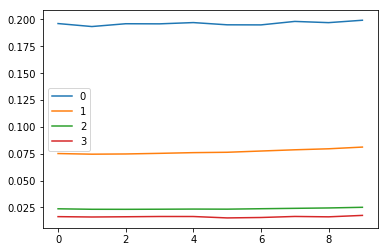

In [40]:
# Inspect the first 10 iterations
# Why the later two activations are close to zero even from the beginning ?
for l in model.act_means[:4]: plt.plot(l[:10])
plt.legend(range(4))

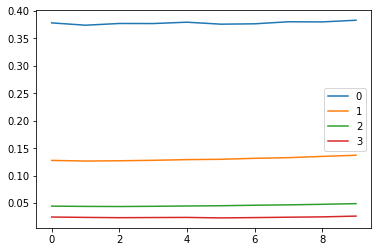

In [41]:
for l in model.act_stds[:4]: plt.plot(l[:10])
plt.legend(range(4))

In [43]:
# WTF is going on with all activations even from the very beginning ?

In [45]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [46]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [48]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())    

In [49]:
#register append_stats as a hook to each top level layers
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [50]:
run.fit(1, learn)

train: [2.29346828125, tensor(0.1596)]
valid: [2.239268359375, tensor(0.2274)]


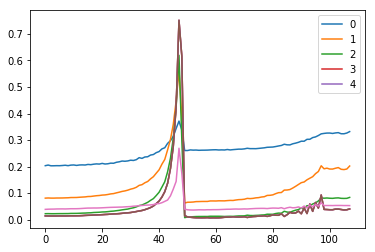

In [54]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

# Is this spike due to gradients with too high learning rate exploding
# that shoot up the magnitude of weights that shoots up for a subset of weights 
# and eventually those gradients hits INF that comes back to 0 ?

In [55]:
#export 
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [56]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)
hooks = [Hook(l, append_stats) for l in children(model)]

In [57]:
run.fit(1, learn)

train: [1.82572828125, tensor(0.3764)]
valid: [0.55763818359375, tensor(0.8196)]


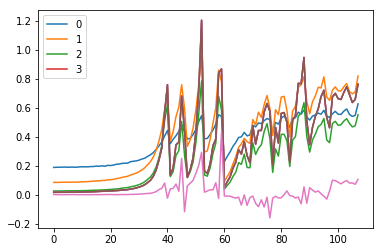

In [58]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

In [59]:
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
    
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self):
        return len(self.items)
    def __iter__(self):
        return iter(self.items)
    def __setitem__(self, i, o):
        self.items[i] = 0
    def __delitem__(self, i):
        del(self.items[i])    
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + '...]'
        return res                

In [60]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [61]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [62]:
t = ListContainer(range(10))
t[[1,2]], t[[False] * 8 + [True, False]]

([1, 2], [8])

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.


In [63]:
#export

from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args):
        self.remove()
    
    def __delitem__(sefl, i):
        self[i].remove()
        super().__delitem__(i)        

    def remove(self):
        for h in self: h.remove()                        

In [64]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [65]:
hooks = Hooks(model, append_stats)
hooks


Hooks (7 items)
[<__main__.Hook object at 0x1a20839eb8>, <__main__.Hook object at 0x1a20839a20>, <__main__.Hook object at 0x1a20839cf8>, <__main__.Hook object at 0x1a207cbcf8>, <__main__.Hook object at 0x1a207cbac8>, <__main__.Hook object at 0x1a207c52b0>, <__main__.Hook object at 0x1a207c55c0>]

In [66]:
hooks.remove()

In [68]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x)

In [69]:
x.mean(), x.std()

(tensor(0.0056), tensor(1.0069))

In [70]:
p = model[0](x)

In [71]:
p.mean(), p.std()

(tensor(0.2109, grad_fn=<MeanBackward0>),
 tensor(0.3220, grad_fn=<StdBackward0>))

In [72]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [73]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4083, grad_fn=<MeanBackward0>),
 tensor(0.6794, grad_fn=<StdBackward0>))

train: [0.12325494140625, tensor(0.9612)]
valid: [0.12872060546875, tensor(0.9582)]
train: [0.087068955078125, tensor(0.9729)]
valid: [0.11952987060546875, tensor(0.9633)]


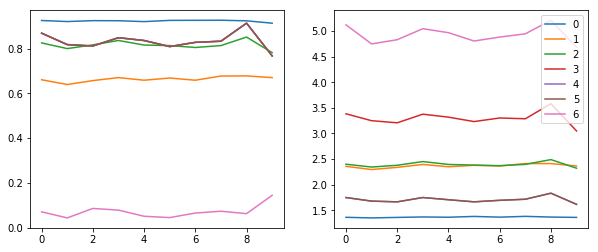

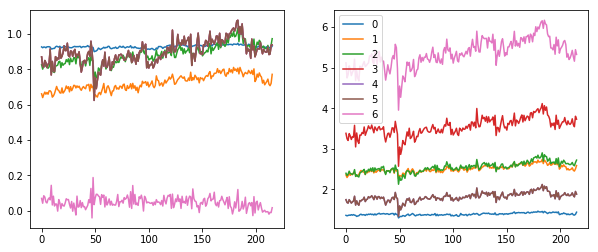

In [75]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(9));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(9));

In [77]:
# Use histogram to see distributions of activations for each layer over iterations

In [79]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])    
    means, stds, hists = hook.stats
    
    means.append(outp.data.mean())
    stds.append(outp.data.std())
    hists.append(outp.data.histc(40, 0, 10))    
    

In [80]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [81]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [82]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [2.2108515625, tensor(0.2283)]
valid: [1.3802357421875, tensor(0.6105)]


In [83]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

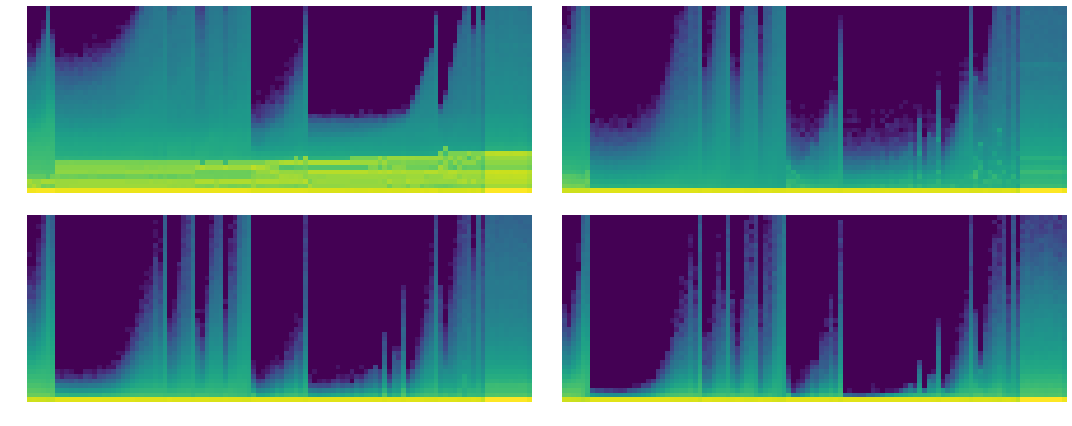

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [113]:
def get_min(h):
    hh = torch.stack(h.stats[2]).t().float()
    return hh[:2].sum(0) / hh.sum(0)

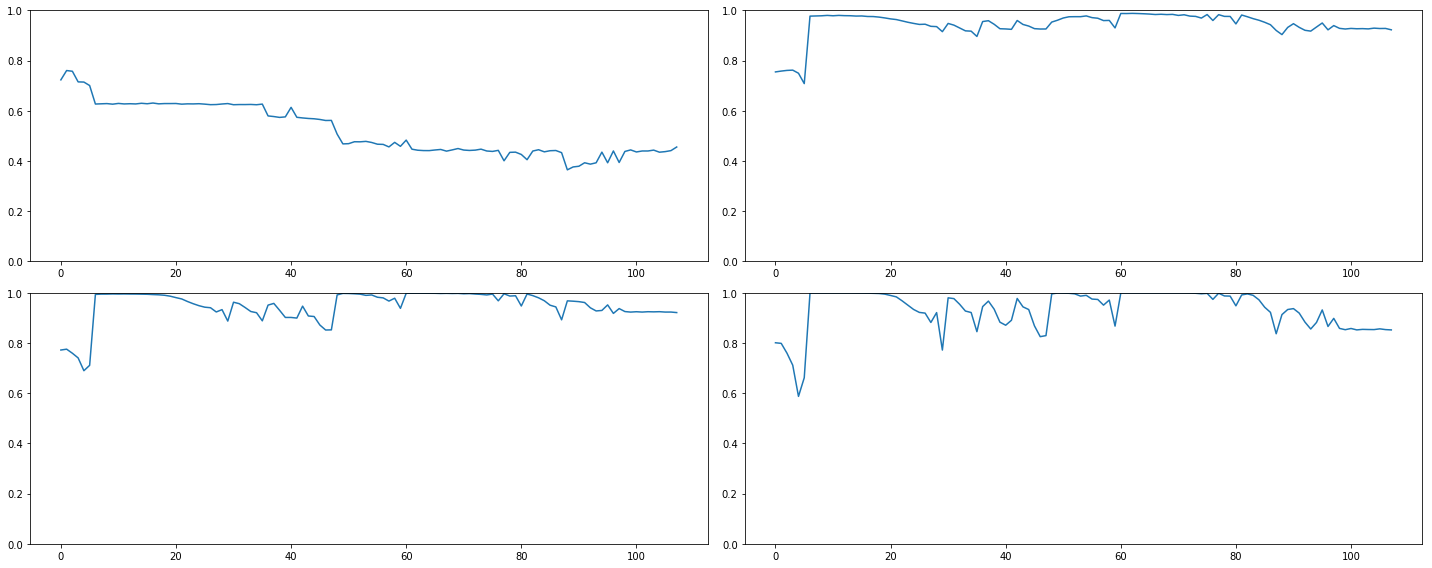

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(20,8))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()    

In [121]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()        
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
        
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs)
    )

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [
        layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs) 
        for i in range(len(nfs) - 1)
    ] + [
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(nfs[-1], data.c)
    ]



def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))



In [119]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    
    means.append(outp.data.mean())
    stds.append(outp.data.std())
    hists.append(outp.data.histc(40, -7, 7))
    

In [122]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.470371015625, tensor(0.8532)]
valid: [0.1369346435546875, tensor(0.9615)]


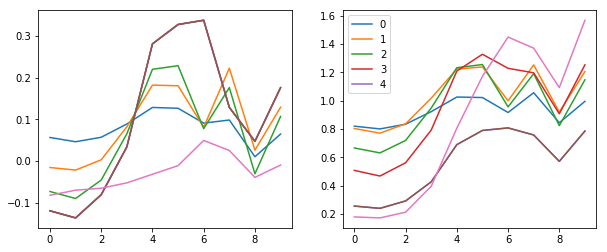

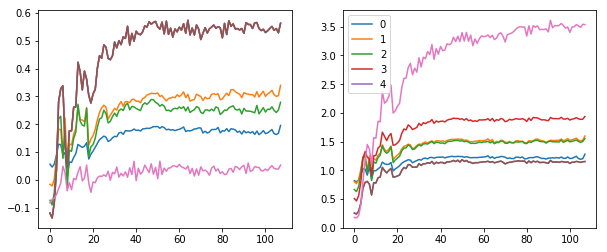

In [123]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

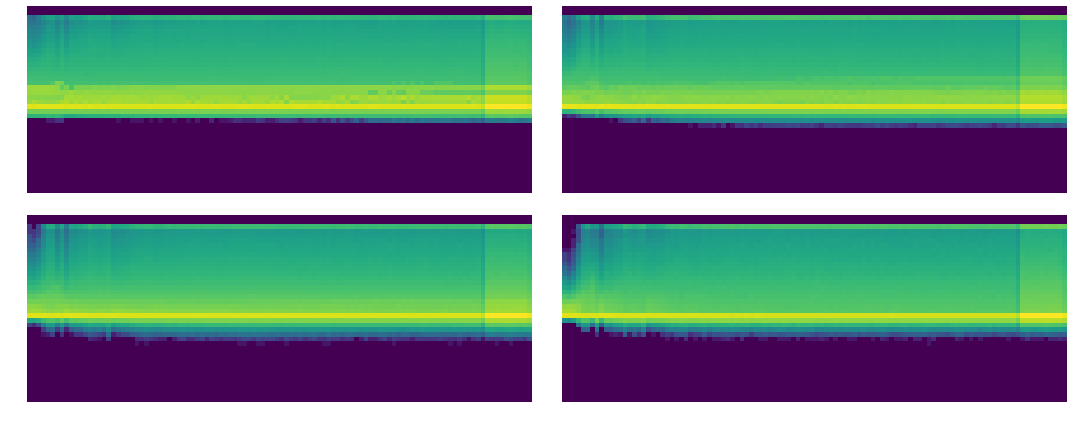

In [124]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [125]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

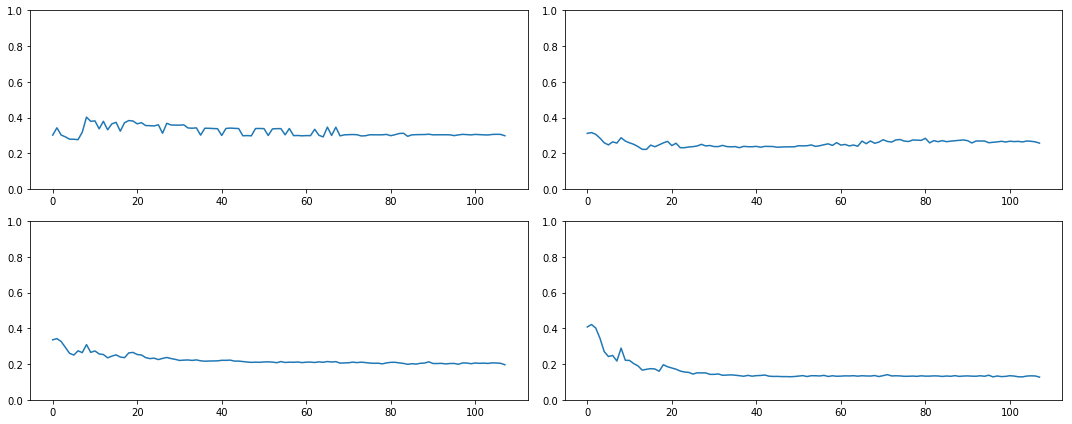

In [126]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [127]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [128]:
shed = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [129]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', shed)])

In [130]:
run.fit(8, learn)

train: [1.1279140625, tensor(0.6443)]
valid: [0.31620673828125, tensor(0.9079)]
train: [0.4354465625, tensor(0.8704)]
valid: [0.18077222900390624, tensor(0.9488)]
train: [0.23234466796875, tensor(0.9282)]
valid: [0.142913134765625, tensor(0.9600)]
train: [0.2621095703125, tensor(0.9207)]
valid: [0.12878599853515624, tensor(0.9644)]
train: [0.1031505859375, tensor(0.9679)]
valid: [0.09916065063476563, tensor(0.9715)]
train: [0.0686146435546875, tensor(0.9788)]
valid: [0.07349996337890626, tensor(0.9788)]
train: [0.05023283203125, tensor(0.9846)]
valid: [0.06452403564453126, tensor(0.9825)]
train: [0.04157580078125, tensor(0.9873)]
valid: [0.06304454345703125, tensor(0.9828)]


In [132]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, uniform=True, cbs=cbfs+[partial(ParamScheduler, 'lr', shed)])

In [133]:
run.fit(8, learn)


train: [1.093870546875, tensor(0.6692)]
valid: [0.2776691650390625, tensor(0.9206)]
train: [0.30720712890625, tensor(0.9063)]
valid: [0.179498583984375, tensor(0.9486)]
train: [0.778707890625, tensor(0.7615)]
valid: [1.698637890625, tensor(0.6016)]
train: [0.355815625, tensor(0.8922)]
valid: [0.14206494140625, tensor(0.9541)]
train: [0.2810419140625, tensor(0.9176)]
valid: [0.132480322265625, tensor(0.9601)]
train: [0.100402841796875, tensor(0.9691)]
valid: [0.08343612670898437, tensor(0.9744)]
train: [0.0737723291015625, tensor(0.9768)]
valid: [0.07812828369140624, tensor(0.9764)]
train: [0.0629607568359375, tensor(0.9805)]
valid: [0.07538132934570313, tensor(0.9775)]
